<div align="center">

# GradCAM demo 1

</div>
This code is an example of how to use the Grad-CAM (Gradient-weighted Class Activation Mapping) technique to visualize which regions of an image a Convolutional Neural Network (CNN) is attending to when making a classification decision. The code imports a pre-trained CNN model trained on a Cats vs Dogs dataset, tests the model on some example images, and computes the Grad-CAM visualization for one of the images.

The resulting heatmap is then processed and overlaid onto the original image to highlight the parts of the image that the CNN model is using to make its prediction.

Overall, the code demonstrates a powerful technique for visualizing the inner workings of CNN models, which can be useful for gaining insights into how these models make their predictions and for debugging and fine-tuning them.






## Importing files from my github repo

In [15]:
!git clone https://github.com/mohamedamine99/Visualizing-what-convnets-learn

fatal: destination path 'Visualizing-what-convnets-learn' already exists and is not an empty directory.


## importing libraries and modules

In [16]:
import os
import shutil

import tensorflow as tf
from tensorflow.keras.models import Model, load_model

import cv2
import matplotlib.pyplot as plt
import numpy as np


## setting up paths and importing a pre-trained model.

In [17]:
CNN_model_path = '/content/Visualizing-what-convnets-learn/models/CNN cats vs dogs model.hdf5'
test_imgs_path = '/content/Visualizing-what-convnets-learn/test images'

In [18]:
# loading a CNN image classifier for cats and dogs imgs
CNN_model = load_model(CNN_model_path)
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 61, 61, 64)      



## Testing and visualizing CNN model predictions



dog.PNG
[[0.99410754]]
0.99410754
2 dogs.PNG
[[0.99938726]]
0.99938726
cat.PNG
[[9.113619e-05]]
9.113619e-05
2 cats.PNG
[[4.815186e-09]]
4.815186e-09


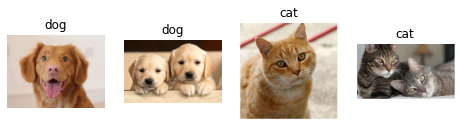

In [19]:
# testing and visualizing the previously 
# loaded CNN model predictions.

labels = ["cat","dog"]
pre_processed_imgs = []
ncols = len(os.listdir(test_imgs_path))
fig = plt.figure(figsize=(8, 5))

for i , img_file in enumerate(os.listdir(test_imgs_path)):
    print(img_file)
    img = cv2.imread(os.path.join(test_imgs_path,img_file))
    if (img is None):
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, ncols, i+1)
    plt.imshow(img)
    plt.axis('off')
    
    # The model accepts (1, 128, 128, 3) input shape
    img = cv2.resize(img,(128,128))
    img = img / 255
    img = np.reshape(img,(1,128,128,3))
    pre_processed_imgs.append(img)

    # feed forward the input through the model
    results = CNN_model.predict(img,verbose = 0)
    print(results)
    results = np.squeeze(results)
    plt.title(labels[np.round(results).astype(int)])

    print(results)
    

## Computing GradCAM : Gradient-weighted Class Activation Mapping.

We start by constructeing our gradient model: we supply (1) the inputs to our pre-trained model, (2) the output of the (presumably) final 4D layer in the network (conv2d_6) and (3) the final output of the activations from the pre-trained model.

This model structure will allow us to calculate the gradients of the final classification output\ predictions with regards to the final conv layer activations.  
In other words we will be computing how important the last feature maps are to the specific class prediction output. This is how GradCAM -Gradient-weighted Class Activation Mapping- got its name.

In [20]:

grads_model = Model(inputs =[CNN_model.input] , 
                    outputs = [CNN_model.get_layer('conv2d_6').output, CNN_model.output])

In [21]:
cat_img = pre_processed_imgs[3]
# create a GradientTape context manager to record
# operations for automatic differentiation
# GradientTape is how tensorflow computes automatic differentiation
with tf.GradientTape() as tape:
    cat_img = tf.cast(cat_img, tf.float32)
    (last_conv_activations , predictions) = grads_model(cat_img)


print(predictions)

# compute the actual gradient
# of the predictions with regards 
# to the last feature map 
grads = tape.gradient(predictions, last_conv_activations )

print(type(grads))
print(grads.shape)
print(np.max(grads))
print(np.min(grads))


tf.Tensor([[4.815168e-09]], shape=(1, 1), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 12, 12, 256)
1.1790323e-09
-1.5655293e-09


Now we will create masks for the gradients and the activations in order to filter out negative values.
we are only interested in the features that have a positive influence on the class of interest, i.e. pixels
whose intensity should be increased in order to increase the specific class prediction.
Negative pixels are likely to belong to other categories in the image.

In [22]:
# Creating masks for grads and last_conv_activations
cast_grads = tf.cast(grads > 0 , tf.float32)
cast_last_conv_activations = tf.cast(last_conv_activations > 0 , tf.float32)
guided_grads = cast_grads * cast_last_conv_activations * grads

# eliminate the batch dimension : (1, 6, 6, 256) --> (6, 6, 256)
last_conv_activations = last_conv_activations[0]
guided_grads = guided_grads[0]

print(np.max(cast_grads))
print(np.min(cast_grads))

print(np.max(cast_last_conv_activations))
print(np.min(cast_last_conv_activations))

print(np.max(guided_grads))
print(np.min(guided_grads))

1.0
0.0
1.0
0.0
1.7790495e-10
0.0


We calculate the weight of each channel of the last feature map i.e how important that channel is to the class prediction (1) and multiply the now ponderated weights by the channels of the feature maps (2).

Each weight is the mean of a 2D channel gradient (that's why axis = (0,1))

In [23]:
# calculate the weights for each channel of the computed guided gradients
weights = tf.reduce_mean(guided_grads, axis = (0,1))

# multiply the weights by the the channels of the last activation layer
weighted_activations = tf.multiply(weights, last_conv_activations)

print(np.max(weights))
print(np.min(weights))
print(weights.shape)

print(np.max(weighted_activations))
print(np.min(weighted_activations))
print(weighted_activations.shape)


3.911345e-12
0.0
(256,)
7.123093e-11
0.0
(12, 12, 256)


In [24]:
# sum all the ponderated channels to obtain the CAM
cam = tf.reduce_sum(weighted_activations, axis = -1)

print(np.max(cam))
print(np.min(cam))
print(cam.shape)

6.884784e-10
1.5142604e-10
(12, 12)


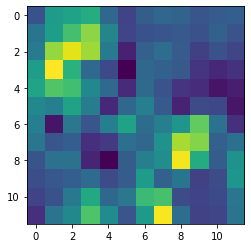

In [25]:
# visualize CAM
plt.imshow(cam)

## Computing and visualizing heatmap

Now that we have computed the CAM we need to process it in order to have our final heatmap:


1.   Resize the CAM to the original input img size
2.   Perform a min max rescaling to have values in [0,1]
3.   Multiply by 255 and convert to uint8



514 293
0
255


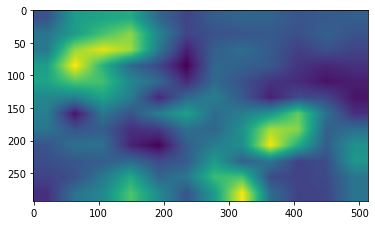

In [26]:
image = cv2.imread('/content/Visualizing-what-convnets-learn/test images/2 cats.PNG')
(w,h) = (image.shape[1], image.shape[0])
print(w,h)
heatmap = cv2.resize(cam.numpy() , (w,h))
heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min()) + 1e-8
heatmap = (heatmap * 255).astype("uint8")
print(np.min(heatmap))
print(np.max(heatmap))

plt.imshow(heatmap)

We overlay our heatm on the original input img

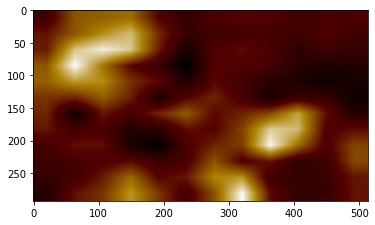

In [27]:
heatmap = cv2.applyColorMap(heatmap, 5)
plt.imshow(heatmap)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
output = cv2.addWeighted(image, 0.3, heatmap, 0.9, 0)
#plt.imshow(cv2.cvtColor(output,cv2.COLOR_BGR2RGB))

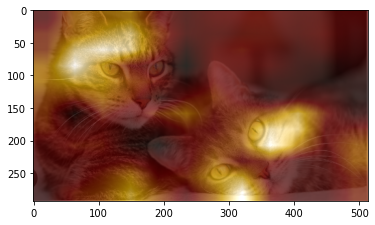

In [28]:
plt.imshow(output)